In [1]:
from tqdm import tqdm_notebook, tqdm
import pandas as pd
from os.path import join as oj
import sys, time
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import pickle as pkl
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
results_folder = "../results"
fnames = sorted([oj(results_folder, fname) for fname in os.listdir(results_folder)]) # filenames in the directory
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) ] 
results = pd.concat(results_list, axis=1).T.infer_objects() # pandas dataframe w/ hyperparams and weights stored

results["final_acc"] = [max(x) for x in results["acc_test"]]
results["min_test_loss"] = [x[-1]for x in results["losses_test"]]
results["num_epochs"] = [len(x) for x in results["losses_test"]]
results["min_train_loss"] = [min(x) for x in results["losses_train"]]
results.learning_rate[results.learning_rate.isnull()] =0.001 # not been in the data
results.num_neurons[results.num_neurons.isnull()] =32 # not been in th|e data
results.num_noise_chars[results.num_noise_chars.isnull()] =4 # not been in the data

100%|██████████| 16/16 [00:00<00:00, 387.76it/s]
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyd

In [3]:
# delete with learning rate 001
#results = results[results.learning_rate !=0.0001]
#duplicates del

results = results[ results.duplicated(subset = ['repeats','learning_rate', 'num_noise_chars','noise', 'num_in_train', 'num_neurons','weight','num_epochs','string_length'],keep ='last') == False]
# results = results[results.string_length ==10]
# results = results[results.noise ==.0]
results = results[results.weight !=.5]
# results = results[results.num_noise_chars == 15]
# # results = results[results.num_in_train == 5]

In [4]:
results.groupby(['weight']).mean()

,repeats,noise,string_length,learning_rate,num_noise_chars,num_neurons,num_in_train,final_acc,min_test_loss,num_epochs,min_train_loss
weight,,,,,,,,,,,
0.0,1.0,0.05,12.5,0.001,30.0,128.0,35.0,83.25,1.414202,50.0,0.000072
0.1,1.0,0.05,12.5,0.001,30.0,128.0,35.0,84.25,0.585505,50.0,0.001596


In [5]:
# get accuracy diff between two
grouped_pairs = results.groupby(['string_length', 'repeats', 'num_in_train','noise','num_neurons', 'num_epochs','num_noise_chars'])
best_diff = -100
best_pair  = None
for  group_name, group in grouped_pairs:
#     print(len(group))
    
    if len(group )>1:  
        first_is_regularized = (group.weight.iloc[0] -group.weight.iloc[1]) >0
        curr_acc_diff = -((group.final_acc.iloc[0] - group.final_acc.iloc[1]))
        
        if first_is_regularized:
            curr_acc_diff = - curr_acc_diff
        if curr_acc_diff > best_diff:
            
            best_diff = curr_acc_diff
            best_pair = group_name
print(best_diff)

5.0


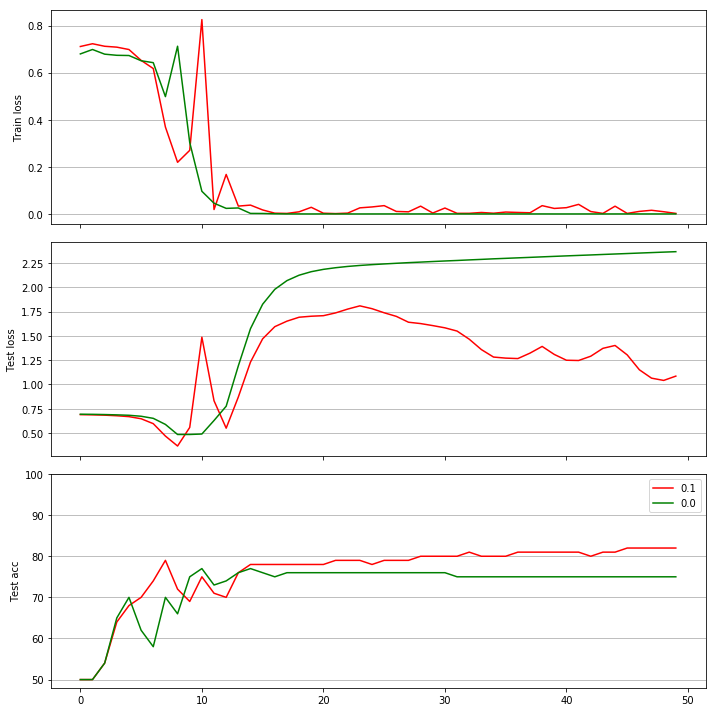

In [6]:
f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for idx, line in results.iterrows():

    if   line["num_in_train"] ==best_pair[2] and  line['string_length'] == best_pair[0] and  line['noise'] ==best_pair[3]and  line['num_epochs'] ==best_pair[5]:
        c = 'g'
        if line["weight"] >0.0:
            c = 'r'
        
        axes[0].plot(line["losses_train"], color =c)
        axes[1].plot(line["losses_test"], color =c)
        axes[2].plot(line["acc_test"], label = line["weight"], color =c)
   
 


axes[0].set_ylabel("Train loss")
axes[0].grid( axis='y')
#axes[0].set_ylim([0, 1])
plt.legend();
axes[1].set_ylabel("Test loss")
axes[1].grid( axis='y')
# axes[1].set_ylim([0, .01])
axes[2].set_ylabel("Test acc")
axes[2].set_ylim([48, 100])
axes[2].grid( axis='y')
plt.tight_layout()
plt.legend();

In [15]:
results[['weight', 'noise', 'final_acc','min_train_loss','string_length', 'num_in_train', 'num_neurons' ]].sort_values(by = ['weight'])

,weight,noise,final_acc,min_train_loss,string_length,num_in_train,num_neurons
23,0.0,0.0,78.0,0.000014,10,20,128
20,0.0,0.2,54.0,0.000013,50,20,128
19,0.0,0.2,60.0,0.000040,50,50,128
4,0.0,0.0,86.0,0.000010,25,50,128
5,0.0,0.2,91.0,0.000004,10,50,128
6,0.0,0.0,81.0,0.000003,25,20,128
7,0.0,0.0,67.0,0.000078,50,20,128
16,0.0,0.2,81.0,0.000043,25,50,128
22,0.0,0.2,60.0,0.000003,25,20,128
12,0.0,0.0,55.0,0.000072,50,50,128
